5.	Estimate the sale price of residential properties by considering factors such as location, number of rooms, square footage, and the property's age to help both buyers and sellers.
# Bengaluru Housing Price Prediction with Location,Area sqft,Number of BHK,Realistic Age Feature
This notebook implements a realistic relationship where house prices decrease as age increases.

## Key Points:
- Houses lose value as they age (depreciation model)
- Newer houses (0-5 years) have premium pricing
- Older houses (20+ years) have significant depreciation
- Age directly impacts the final price calculation

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import warnings
import pandas as pd
from sklearn.exceptions import DataConversionWarning

matplotlib.rcParams["figure.figsize"] = (20,10)
plt.style.use('default')

## Data Loading and Initial Processing

In [2]:
# Load the original dataset
df2 = pd.read_csv("Bengaluru_House_Data_realistic_age.csv")
print(f"Original dataset shape: {df2.shape}")
df2.head()

Original dataset shape: (10148, 10)


,location,size,total_sqft,bath,price,bhk,price_per_sqft,age,age_factor,original_price
0,1st Block Jayanagar,4 BHK,2850.0,4.0,402.32,4,15017.543860,6,0.94,428.0
1,1st Block Jayanagar,3 BHK,1630.0,3.0,149.38,3,11901.840491,19,0.77,194.0
2,1st Block Jayanagar,3 BHK,1875.0,2.0,131.60,3,12533.333333,28,0.56,235.0
3,1st Block Jayanagar,3 BHK,1200.0,2.0,111.80,3,10833.333333,14,0.86,130.0
4,1st Block Jayanagar,2 BHK,1235.0,2.0,133.20,2,11983.805668,10,0.90,148.0


In [3]:
# Data cleaning - remove null values
print("Null values before cleaning:")
print(df2.isnull().sum())

df3 = df2.dropna()
print(f"\nAfter removing null values: {df3.shape}")

Null values before cleaning:
location          0
size              0
total_sqft        0
bath              0
price             0
bhk               0
price_per_sqft    0
age               0
age_factor        0
original_price    0
dtype: int64

After removing null values: (10148, 10)


In [4]:
# Extract BHK from size column
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
print("BHK distribution:")
print(df3['bhk'].value_counts().sort_index())

BHK distribution:
bhk
1      518
2     4754
3     3980
4      688
5      103
6       57
7       19
8       16
9        8
10       1
11       2
13       1
16       1
Name: count, dtype: int64


In [5]:
# Function to convert sqft ranges to numbers
def convert_sqft_to_num(x):
    if isinstance(x, (int, float)):
        return x
    if isinstance(x, str):
        tokens = x.split('-')
        if len(tokens) == 2:
            return (float(tokens[0]) + float(tokens[1])) / 2
        try:
            return float(x)
        except:
            return None
    return None

df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num)
df4 = df4.dropna()  # Remove any remaining null values
print(f"After sqft conversion: {df4.shape}")

After sqft conversion: (10148, 10)


## Location Processing and Outlier Removal

In [6]:
# Clean location names and group rare locations
df4.location = df4.location.apply(lambda x: x.strip())
location_stats = df4.groupby('location')['location'].agg('count').sort_values(ascending=False)

# Group locations with less than 10 data points as 'other'
location_stats_less_than_10 = location_stats[location_stats <= 10]
df4.location = df4.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

print(f"Number of unique locations after grouping: {len(df4.location.unique())}")

Number of unique locations after grouping: 178


In [7]:
# Remove outliers based on sqft per BHK (minimum 300 sqft per bedroom)
df5 = df4[~(df4.total_sqft/df4.bhk < 300)]
print(f"After removing sqft/bhk outliers: {df5.shape}")

After removing sqft/bhk outliers: (10148, 10)


In [8]:
# Calculate price per sqft for outlier detection
df5['price_per_sqft'] = df5['price'] * 100000 / df5['total_sqft']

# Remove price per sqft outliers using mean ± std dev
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft > (m-st)) & (subdf.price_per_sqft <= (m+st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

df6 = remove_pps_outliers(df5)
print(f"After removing price outliers: {df6.shape}")

After removing price outliers: (7025, 10)


In [9]:
# Remove bathroom outliers (max bathrooms = bedrooms + 2)
df7 = df6[df6.bath < df6.bhk + 2]
print(f"Final cleaned dataset shape: {df7.shape}")
df7.head()

Final cleaned dataset shape: (7025, 10)


,location,size,total_sqft,bath,price,bhk,price_per_sqft,age,age_factor,original_price
0,1st Phase JP Nagar,4 BHK,2825.0,4.0,187.50,4,6637.168142,20,0.75,250.0
1,1st Phase JP Nagar,3 BHK,2065.0,4.0,165.90,3,8033.898305,18,0.79,210.0
2,1st Phase JP Nagar,3 BHK,2024.0,3.0,111.47,3,5507.411067,22,0.71,157.0
3,1st Phase JP Nagar,2 BHK,1394.0,2.0,90.00,2,6456.241033,10,0.90,100.0
4,1st Phase JP Nagar,2 BHK,1077.0,2.0,64.17,2,5958.217270,23,0.69,93.0


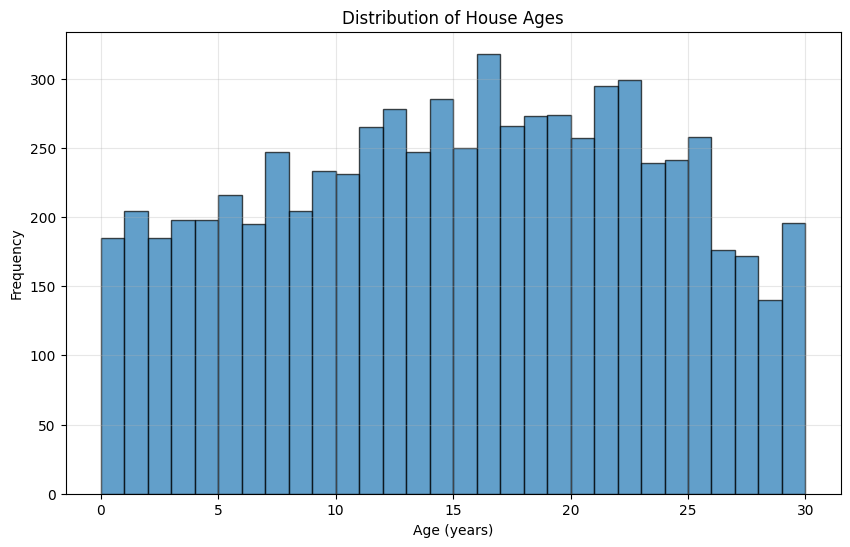

In [10]:
# Plot age distribution
plt.figure(figsize=(10, 6))
plt.hist(df7['age'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of House Ages')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
# Implement realistic depreciation model
def calculate_age_factor(age):
    """
    Calculate depreciation factor based on house age
    - Brand new (0-2 years): 100% value
    - New (3-5 years): 95-98% value  
    - Good (6-10 years): 90-95% value
    - Average (11-15 years): 85-90% value
    - Old (16-20 years): 75-85% value
    - Very old (21-25 years): 65-75% value
    - Ancient (26+ years): 50-65% value
    """
    if age <= 2:
        return 1.0  # No depreciation for very new houses
    elif age <= 5:
        return 1.0 - (age - 2) * 0.017  # 1.7% per year depreciation
    elif age <= 10:
        return 0.95 - (age - 5) * 0.01  # 1% per year depreciation
    elif age <= 15:
        return 0.90 - (age - 10) * 0.01  # 1% per year depreciation
    elif age <= 20:
        return 0.85 - (age - 15) * 0.02  # 2% per year depreciation
    elif age <= 25:
        return 0.75 - (age - 20) * 0.02  # 2% per year depreciation
    else:
        return max(0.50, 0.65 - (age - 25) * 0.03)  # 3% per year, minimum 50%

# Apply depreciation to prices
df8 = df7.copy()
df8['age_factor'] = df8['age'].apply(calculate_age_factor)
df8['original_price'] = df8['price'].copy()  # Keep original price for comparison
df8['price'] = df8['price'] * df8['age_factor']  # Apply depreciation

print("Price adjustment based on age:")
print(f"Average age factor: {df8['age_factor'].mean():.3f}")
print(f"Price reduction range: {(1-df8['age_factor'].max())*100:.1f}% to {(1-df8['age_factor'].min())*100:.1f}%")

Price adjustment based on age:
Average age factor: 0.818
Price reduction range: 0.0% to 50.0%


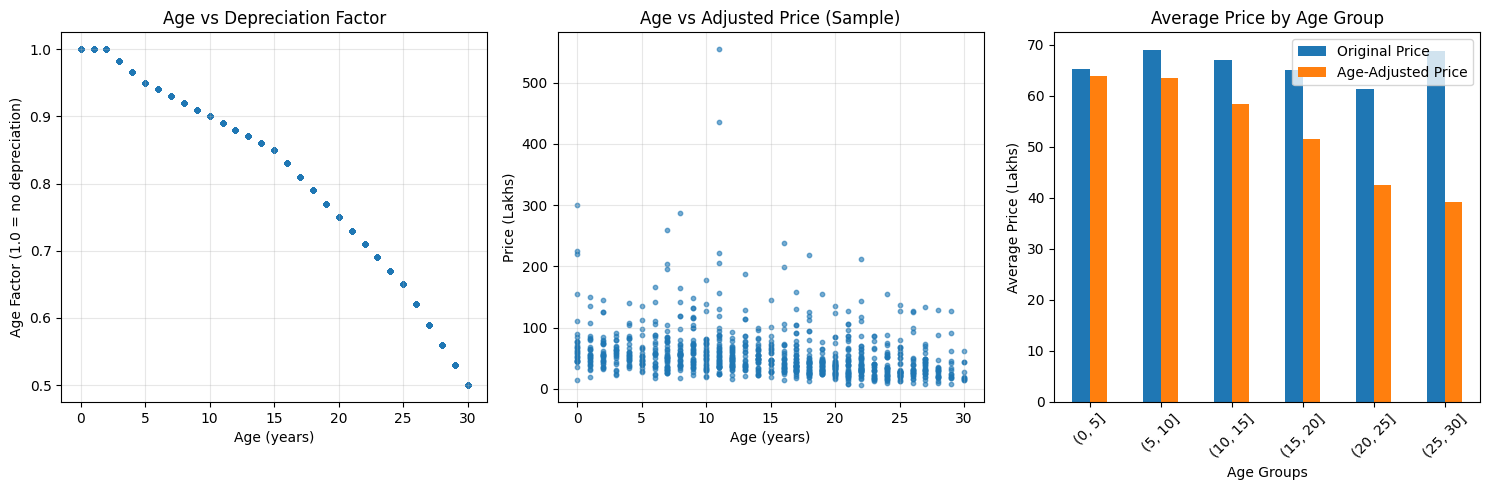

In [13]:
# Visualize age vs price relationship
warnings.filterwarnings('ignore', category=FutureWarning)
plt.figure(figsize=(15, 5))

# Plot 1: Age vs Age Factor
plt.subplot(1, 3, 1)
plt.scatter(df8['age'], df8['age_factor'], alpha=0.6, s=10)
plt.title('Age vs Depreciation Factor')
plt.xlabel('Age (years)')
plt.ylabel('Age Factor (1.0 = no depreciation)')
plt.grid(True, alpha=0.3)

# Plot 2: Age vs Price (sample)
plt.subplot(1, 3, 2)
sample_data = df8.sample(1000)  # Sample for better visualization
plt.scatter(sample_data['age'], sample_data['price'], alpha=0.6, s=10)
plt.title('Age vs Adjusted Price (Sample)')
plt.xlabel('Age (years)')
plt.ylabel('Price (Lakhs)')
plt.grid(True, alpha=0.3)

# Plot 3: Price comparison
plt.subplot(1, 3, 3)
age_groups = df8.groupby(pd.cut(df8['age'], bins=[0, 5, 10, 15, 20, 25, 30])).agg({
    'original_price': 'mean',
    'price': 'mean'
})
age_groups.plot(kind='bar', ax=plt.gca())
plt.title('Average Price by Age Group')
plt.xlabel('Age Groups')
plt.ylabel('Average Price (Lakhs)')
plt.xticks(rotation=45)
plt.legend(['Original Price', 'Age-Adjusted Price'])

plt.tight_layout()
plt.show()

## Model Training with Realistic Age Feature

In [14]:
# Prepare data for modeling (drop unnecessary columns for training)
df_model = df8.drop(['size', 'price_per_sqft', 'age_factor', 'original_price'], axis='columns')

# One-hot encode location
dummies = pd.get_dummies(df_model.location)
df_encoded = pd.concat([df_model, dummies.drop('other', axis='columns')], axis='columns')
df_final = df_encoded.drop('location', axis='columns')

print(f"Final dataset for training: {df_final.shape}")
print(f"Features: {df_final.columns[:10].tolist()}... (+{len(df_final.columns)-10} more location features)")

Final dataset for training: (7025, 182)
Features: ['total_sqft', 'bath', 'price', 'bhk', 'age', '1st Phase JP Nagar', '5th Phase JP Nagar', '6th Phase JP Nagar', '7th Phase JP Nagar', '8th Phase JP Nagar']... (+172 more location features)


In [15]:
# Split features and target
X = df_final.drop(['price'], axis='columns')
y = df_final.price

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFirst 5 feature columns: {X.columns[:5].tolist()}")
print(f"Age is at index: {list(X.columns).index('age')}")

Feature matrix shape: (7025, 181)
Target vector shape: (7025,)

First 5 feature columns: ['total_sqft', 'bath', 'bhk', 'age', '1st Phase JP Nagar']
Age is at index: 3


In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate the model
train_score = lr_model.score(X_train, y_train)
test_score = lr_model.score(X_test, y_test)

print(f"Training R² Score: {train_score:.4f}")
print(f"Testing R² Score: {test_score:.4f}")

# Cross-validation
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
cv_scores = cross_val_score(LinearRegression(), X, y, cv=cv)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Training R² Score: 0.8330
Testing R² Score: 0.8492

Cross-validation scores: [0.84923753 0.80043953 0.88101519 0.8383628  0.86204524]
Mean CV Score: 0.8462 (+/- 0.0539)


## Prediction Function and Testing

In [ ]:
def predict_price_with_age(location, sqft, bath, bhk, age):
    """
    Predict house price considering age depreciation
    """
    # Find location index
    try:
        loc_index = np.where(X.columns == location)[0][0]
    except:
        print(f"Warning: Location '{location}' not found. Using 'other' category.")
        loc_index = -1
    
    # Create feature vector
    x = np.zeros(len(X.columns))
    x[0] = sqft      # total_sqft
    x[1] = bath      # bath
    x[2] = bhk       # bhk  
    x[3] = age       # age
    
    if loc_index >= 0:
        x[loc_index] = 1
    
    predicted_price = lr_model.predict([x])[0]
    return predicted_price

def predict_with_age_analysis(location, sqft, bath, bhk, age):
    """
    Predict price and show how age affects the prediction
    """
    current_price = predict_price_with_age(location, sqft, bath, bhk, age)
    new_house_price = predict_price_with_age(location, sqft, bath, bhk, 0)
    
    depreciation = (new_house_price - current_price) / new_house_price * 100
    
    print(f"Property: {bhk} BHK, {bath} Bath, {sqft} sqft in {location}")
    print(f"Age: {age} years")
    print(f"Predicted Price: ₹{current_price:.2f} Lakhs")
    print(f"New House Price (0 years): ₹{new_house_price:.2f} Lakhs")
    print(f"Depreciation due to age: {depreciation:.1f}%")
    print("-" * 50)
    
    return current_price


In [18]:
warnings.filterwarnings('ignore', category=UserWarning)
predict_with_age_analysis('Whitefield', 8000, 7, 5, 5)
predict_with_age_analysis('Banashankari', 3000, 4, 3, 8)
predict_with_age_analysis('1st Phase JP Nagar', 2500, 3, 3, 2)
predict_with_age_analysis('Indira Nagar', 4000, 5, 4, 0)

Property: 5 BHK, 7 Bath, 8000 sqft in Whitefield
Age: 5 years
Predicted Price: ₹335.43 Lakhs
New House Price (0 years): ₹342.88 Lakhs
Depreciation due to age: 2.2%
--------------------------------------------------
Property: 3 BHK, 4 Bath, 3000 sqft in Banashankari
Age: 8 years
Predicted Price: ₹127.52 Lakhs
New House Price (0 years): ₹139.45 Lakhs
Depreciation due to age: 8.6%
--------------------------------------------------
Property: 3 BHK, 3 Bath, 2500 sqft in 1st Phase JP Nagar
Age: 2 years
Predicted Price: ₹139.19 Lakhs
New House Price (0 years): ₹142.17 Lakhs
Depreciation due to age: 2.1%
--------------------------------------------------
Property: 4 BHK, 5 Bath, 4000 sqft in Indira Nagar
Age: 0 years
Predicted Price: ₹231.38 Lakhs
New House Price (0 years): ₹231.38 Lakhs
Depreciation due to age: 0.0%
--------------------------------------------------


231.38164312350003

In [19]:
# Test the prediction function with age analysis
warnings.filterwarnings('ignore', category=UserWarning)
print("🏠 REALISTIC AGE-BASED PRICE PREDICTIONS")
print("=" * 60)

# Test same property with different ages
test_cases = [
    {'location': 'Indira Nagar', 'sqft': 1200, 'bath': 2, 'bhk': 2, 'age': 0, 'desc': 'Brand New'},
    {'location': 'Indira Nagar', 'sqft': 1200, 'bath': 2, 'bhk': 2, 'age': 8, 'desc': 'Good Condition'},
    {'location': 'Indira Nagar', 'sqft': 1200, 'bath': 2, 'bhk': 2, 'age': 25, 'desc': 'Old House'}
]

for case in test_cases:
    print(f"\n{case['desc']} House:")
    predict_with_age_analysis(case['location'], case['sqft'], case['bath'], case['bhk'], case['age'])

🏠 REALISTIC AGE-BASED PRICE PREDICTIONS

Brand New House:
Property: 2 BHK, 2 Bath, 1200 sqft in Indira Nagar
Age: 0 years
Predicted Price: ₹115.53 Lakhs
New House Price (0 years): ₹115.53 Lakhs
Depreciation due to age: 0.0%
--------------------------------------------------

Good Condition House:
Property: 2 BHK, 2 Bath, 1200 sqft in Indira Nagar
Age: 8 years
Predicted Price: ₹103.60 Lakhs
New House Price (0 years): ₹115.53 Lakhs
Depreciation due to age: 10.3%
--------------------------------------------------

Old House House:
Property: 2 BHK, 2 Bath, 1200 sqft in Indira Nagar
Age: 25 years
Predicted Price: ₹78.26 Lakhs
New House Price (0 years): ₹115.53 Lakhs
Depreciation due to age: 32.3%
--------------------------------------------------


In [20]:
# Compare different locations with age effect
print("\n🌟 LOCATION COMPARISON WITH AGE EFFECT")
print("=" * 60)

locations_test = ['Whitefield', 'Electronic City', 'Hebbal', 'Sarjapur  Road']
ages_test = [5, 15, 25]
warnings.filterwarnings('ignore', category=UserWarning)
for location in locations_test:
    print(f"\n📍 {location} - 3 BHK, 3 Bath, 1500 sqft:")
    for age in ages_test:
        price = predict_price_with_age(location, 1500, 3, 3, age)
        print(f"  {age} years old: ₹{price:.2f} Lakhs")


🌟 LOCATION COMPARISON WITH AGE EFFECT

📍 Whitefield - 3 BHK, 3 Bath, 1500 sqft:
  5 years old: ₹68.31 Lakhs
  15 years old: ₹53.40 Lakhs
  25 years old: ₹38.50 Lakhs

📍 Electronic City - 3 BHK, 3 Bath, 1500 sqft:
  5 years old: ₹62.49 Lakhs
  15 years old: ₹47.59 Lakhs
  25 years old: ₹32.68 Lakhs

📍 Hebbal - 3 BHK, 3 Bath, 1500 sqft:
  5 years old: ₹90.94 Lakhs
  15 years old: ₹76.03 Lakhs
  25 years old: ₹61.13 Lakhs

📍 Sarjapur  Road - 3 BHK, 3 Bath, 1500 sqft:
  5 years old: ₹71.94 Lakhs
  15 years old: ₹57.03 Lakhs
  25 years old: ₹42.13 Lakhs


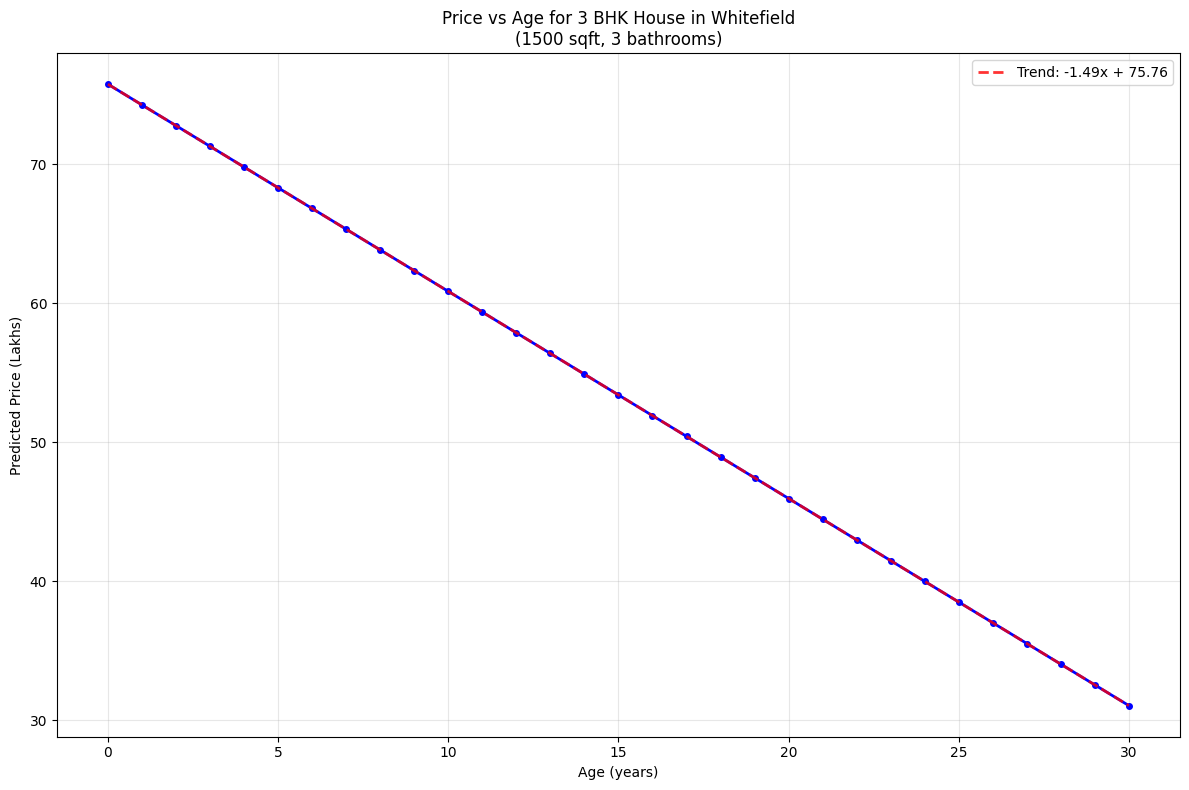


Price Analysis for Whitefield:
New house (0 years): ₹75.76 Lakhs
30-year old house: ₹31.04 Lakhs
Total depreciation: ₹44.72 Lakhs (59.0%)


In [21]:
# Create age impact visualization
warnings.filterwarnings('ignore', category=UserWarning)
ages = range(0, 31)
sample_location = 'Whitefield'
sample_sqft = 1500
sample_bath = 3
sample_bhk = 3

prices_by_age = [predict_price_with_age(sample_location, sample_sqft, sample_bath, sample_bhk, age) for age in ages]

plt.figure(figsize=(12, 8))
plt.plot(ages, prices_by_age, 'bo-', linewidth=2, markersize=4)
plt.title(f'Price vs Age for {sample_bhk} BHK House in {sample_location}\n({sample_sqft} sqft, {sample_bath} bathrooms)')
plt.xlabel('Age (years)')
plt.ylabel('Predicted Price (Lakhs)')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(ages, prices_by_age, 1)
p = np.poly1d(z)
plt.plot(ages, p(ages), "r--", alpha=0.8, linewidth=2, label=f'Trend: {z[0]:.2f}x + {z[1]:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

price_drop = prices_by_age[0] - prices_by_age[-1]
percentage_drop = (price_drop / prices_by_age[0]) * 100
print(f"\nPrice Analysis for {sample_location}:")
print(f"New house (0 years): ₹{prices_by_age[0]:.2f} Lakhs")
print(f"30-year old house: ₹{prices_by_age[-1]:.2f} Lakhs")
print(f"Total depreciation: ₹{price_drop:.2f} Lakhs ({percentage_drop:.1f}%)")